In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

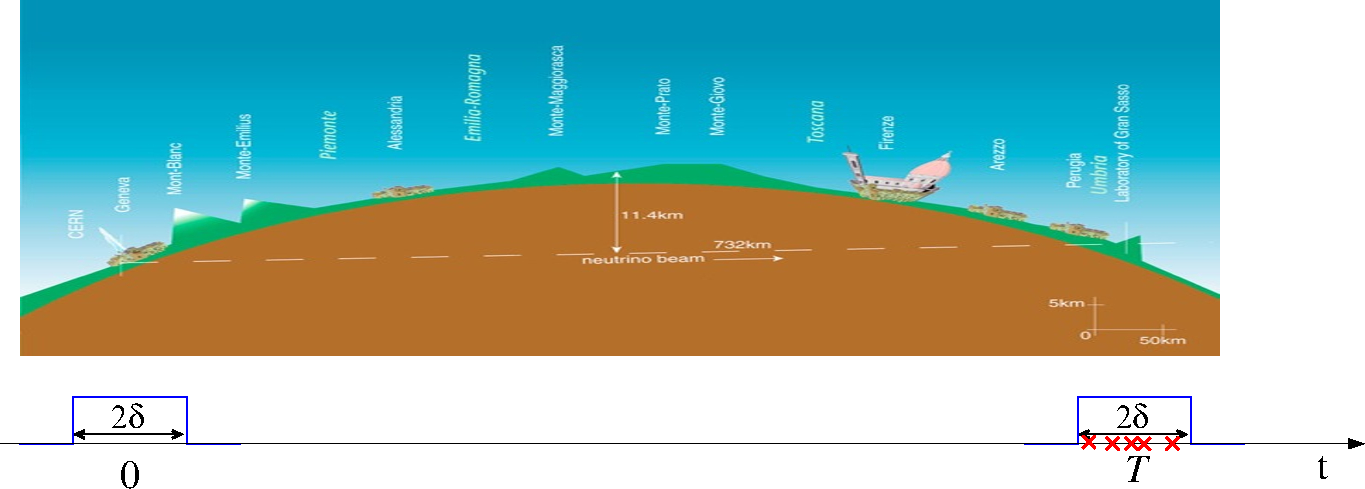

In [2]:
# unit is us
delta=5.25
T=2440
#number of measurements
N=10000

In [3]:
def runToys(Nexp=10000):
    d ={ 'mean':[], 'median':[], 'midpoint':[]}
    for i in np.arange(Nexp):
        data=np.random.uniform(T-delta,T+delta,size=N)
        d['mean'].append(  np.mean(data) )
        d['median'].append(  np.median(data) )
        d['midpoint'].append( (np.max(data)+np.min(data))/2  )
    return d

estims=pd.DataFrame( runToys() )
estims.describe()

mean        median      midpoint
count  10000.000000  10000.000000  10000.000000
mean    2440.000115   2440.000318   2440.000003
std        0.030157      0.051952      0.000746
min     2439.887580   2439.814047   2439.994756
25%     2439.979953   2439.965363   2439.999646
50%     2440.000035   2440.000727   2440.000004
75%     2440.020418   2440.035222   2440.000363
max     2440.110779   2440.211491   2440.004059

expected error of mean is 0.030310889132455353
rms of mean is 0.03015534259805199 +/- 0.00015077671299025997
rms of median is 0.05194895565598013 +/- 0.00025974477827990066
rms of midpoint is 0.0007456201119749105 +/- 3.728100559874552e-06
sigma(midpoint)/sigma(mean)=0.024725970515854026


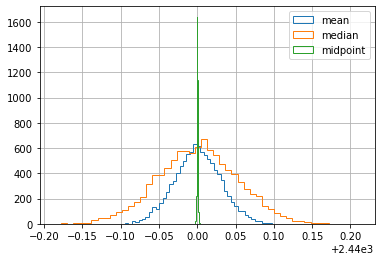

In [4]:
estimerr={}
estimerr['mean']=2*delta/np.sqrt(N*12)
print("expected error of mean is "+str(estimerr['mean']))
for col in estims.columns:
    estimerr[col]=np.std(estims[col])
    print( "rms of "+col+" is "+str(estimerr[col]) + " +/- " + str(estimerr[col]/(2*np.sqrt(len(estims[col])))) )
    estims[col].hist(bins=50, 
             histtype='step', 
             label=col)
l=plt.legend()
print("sigma(midpoint)/sigma(mean)="+str(estimerr['midpoint']/estimerr['mean']))

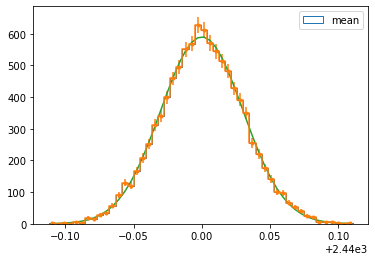

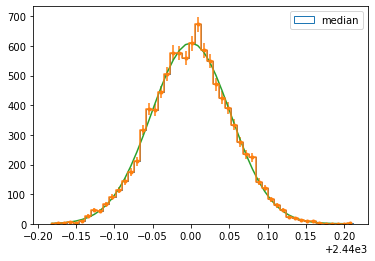

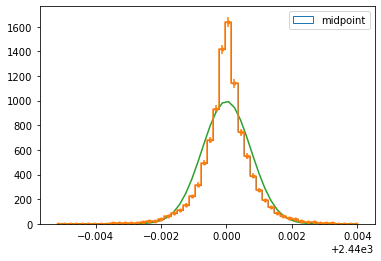

In [5]:
#compare distribution of estimators with normal
for col in estims.columns:
    (y,bin_edges,patches)=plt.hist(estims[col],bins=50,histtype='step',label=col)
    x = 0.5*(bin_edges[1:] + bin_edges[:-1])
    binwidth=x[1]-x[0]
    plt.errorbar(
        x,
        y,
        yerr = np.sqrt(y),
        marker = '.',
        drawstyle = 'steps-mid'
    )
    plt.legend()
    plt.plot(x, 
             len(estims[col]) * stats.norm.pdf(x, T, estimerr[col]) * binwidth    
            )
    plt.show()

In [6]:
# read from file a realistic time pdf f(t), where t is the start time, with expected value=0
tpdf = pd.read_fwf("http://ggrazian.web.cern.ch/ggrazian/Corso2021_datafiles/NeutrinoTimePdf.dat")

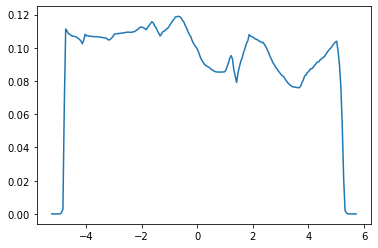

In [7]:
p=plt.plot(tpdf['t'], tpdf['f'])

In [8]:
binWidth=tpdf['t'].iat[1]-tpdf['t'].iat[0]
def timePdf(t, Tflight):
    t-= Tflight
    bin=int( (t-tpdf['t'].iat[0])/binWidth+0.5 )
    bin=np.maximum( 0, np.minimum(bin, len(tpdf)-1) )
    return tpdf['f'].iat[bin]

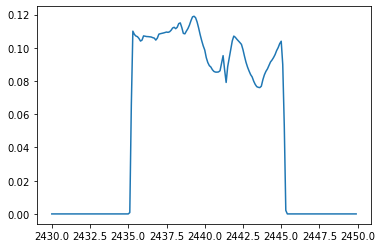

In [9]:
myx=np.arange(T-10,T+10,0.1)
p=plt.plot(myx , [timePdf(x,T) for x in myx]  )

In [10]:
def accRejMC(Np=N):
    expt=[]
    while len(expt)<Np:
        x=np.random.uniform(T-5.,T+5.5)
        y=np.random.uniform(0, 0.12)
        if y < timePdf(x,T): expt.append(x)
    return expt

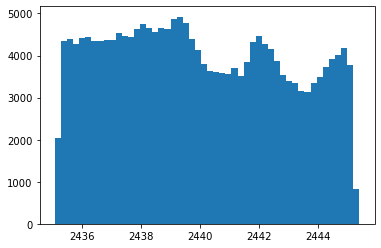

In [11]:
h= plt.hist( accRejMC(200000), bins=50)

In [12]:
from scipy.optimize import minimize
tdata=accRejMC(10000)

def mLL(Tflight):
    ft= [np.maximum(1.e-9, timePdf(t, Tflight)) for t in tdata]
    return -sum( np.log( ft ) )

initT=[ np.mean(tdata) ]

fitResult = minimize(mLL, initT, method='Nelder-Mead', options={'maxiter':1000, 'return_all':True} )
fitResult

       allvecs: [array([2440.00765924]), array([2440.00765924]), array([2440.00765924]), array([2440.00765924]), array([2440.00765924]), array([2440.00765924]), array([2440.00765924]), array([2440.00765924]), array([2440.00765924]), array([2440.00765924]), array([2440.00765924]), array([2440.00765924]), array([2440.00765924]), array([2439.99276662]), array([2440.00021293]), array([2440.00021293]), array([2440.00021293]), array([2440.00114372]), array([2440.00114372]), array([2440.00160911]), array([2440.00160911]), array([2440.00160911]), array([2440.00160911]), array([2440.00160911]), array([2440.00160911]), array([2440.00160911])]
 final_simplex: (array([[2440.00160911],
       [2440.00160184]]), array([23049.63187102, 23049.63187102]))
           fun: 23049.63187102133
       message: 'Optimization terminated successfully.'
          nfev: 57
           nit: 26
        status: 0
       success: True
             x: array([2440.00160911])

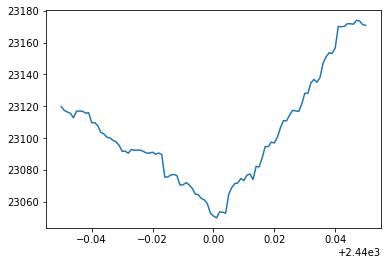

In [13]:
tryT= np.arange( 2439.950, 2440.050, 0.001 )
p=plt.plot(  tryT, [mLL(t) for t in tryT ] )

In [14]:
N=10000
def runSimulation(Nexp=100):
    global tdata
    d ={ 'mean':[], 'median':[], 'midpoint':[], 'ML':[]}
    for i in np.arange(Nexp):
        tdata= accRejMC(N)
        themean= np.mean(tdata)
        d['mean'].append( themean  )
        d['median'].append(  np.median(tdata) )
        d['midpoint'].append( (np.max(tdata)+np.min(tdata))/2  )
        fitResult = minimize(mLL, [ themean ], method='Nelder-Mead', options={'maxiter':1000})
        d['ML'].append( fitResult.x[0]  )
    return d

estims=pd.DataFrame( runSimulation(100) )

mean of mean is 2439.9986106054653 +/- 0.0029924883317220003
rms of mean is 0.029924883317220003 +/- 0.0014962441658610002
mean of median is 2439.762439291492 +/- 0.0045499822514852495
rms of median is 0.045499822514852496 +/- 0.0022749911257426247
mean of midpoint is 2440.2400340942204 +/- 0.0020136357273172014
rms of midpoint is 0.020136357273172013 +/- 0.0010068178636586007
mean of ML is 2439.999974353988 +/- 0.00025538276771617044
rms of ML is 0.002553827677161704 +/- 0.00012769138385808522
sigma(midpoint)/sigma(mean)=0.6728967682084404


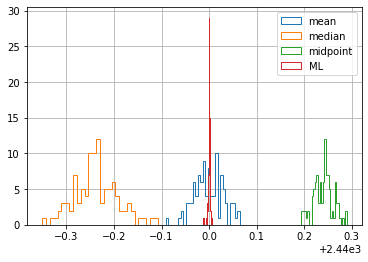

In [16]:
estimerr={}
for col in estims.columns:
    estimerr[col]=np.std(estims[col])
    print( "mean of "+col+" is "+str(np.mean(estims[col])) + " +/- " + str(estimerr[col]/(np.sqrt(len(estims[col])))) )
    print( "rms of "+col+" is "+str(estimerr[col]) + " +/- " + str(estimerr[col]/(2*np.sqrt(len(estims[col])))) )
    estims[col].hist(bins=30, 
             histtype='step', 
             label=col)
l=plt.legend()
print("sigma(midpoint)/sigma(mean)="+str(estimerr['midpoint']/estimerr['mean']))